### Automatic Ticket Classification Assignment 
* Dharmendra Kumar – Group Facilitator
* Divakar B

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [5]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import NMF

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [6]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
###View the dimensions of dataframe
df.shape

(78313, 22)

#### The dataset has 78,313 customer complaints and 22 features.
#### The customer complaint is in "_source.complaint_what_happened" column

In [9]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

#### Assign new column names

In [10]:
# Remove the leading underscores from all column names
df.columns = [re.sub('^_', '', col) for col in df.columns]
list(df.columns)



['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [11]:
## Remove 'source' from column names beginning with 'source.'
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [12]:
df.columns


Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [13]:
# View the info of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

* There are many columns with missing values.
* There is only one numerical column: score.

In [14]:
### we remove the complaint rows that are blank
# Counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

57241

##### 57241 rows in the data have blanks under complaints column

In [15]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)


In [16]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)


In [17]:
# Again counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

0

In [18]:
## View the shape of modified dataframe
df.shape

(21072, 22)

##### We have removed 78313 - 21072 = 57241 rows that contained blank under complaints column

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
## View first five rows of complaint column
df['complaint_what_happened'].head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_what_happened, dtype: object

In [20]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [21]:
# Apply data cleaning to the complaints_what_happened column
df['complaints'] = df['complaint_what_happened'].apply(clean_text)
df.head()



,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


##### After performing cleaning operations, we do the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [22]:
# Function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str


In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].apply(lemmatization)})

# View the dataframe
df_clean.head()

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...


In [24]:
df_clean

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...


In [25]:
df_clean.shape

(21072, 2)

In [26]:
import swifter

In [27]:

#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)



Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [28]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent upgrade anniversary date agent informati...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son check chase account fund bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,risk consumer chase bank app chase year bankin...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




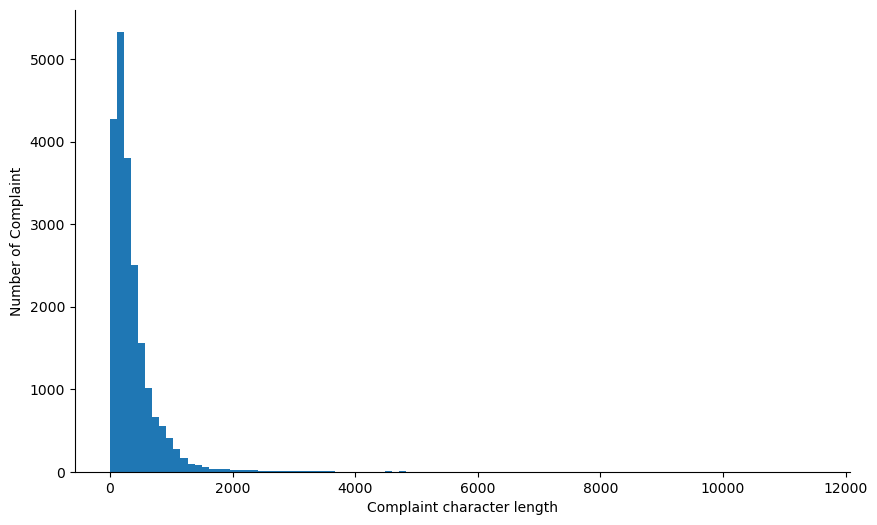

In [29]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();



#### Find the top 40 words by frequency among all the articles after processing the text.

In [30]:
from wordcloud import WordCloud, STOPWORDS

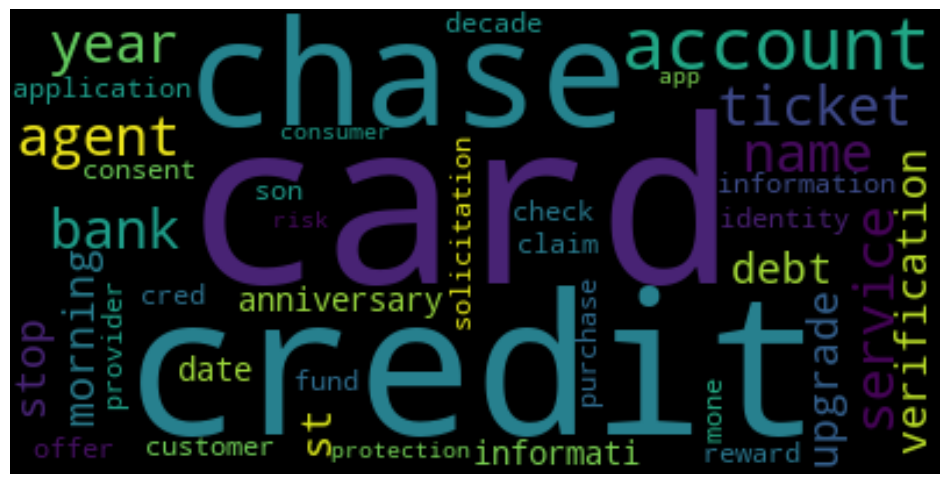

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [32]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son check chase account fund bank account mone...,son check chase account fund bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_unigram(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [34]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,account,46898
1,chase,33634
2,credit,32001
3,card,30075
4,payment,21070
5,bank,18799
6,time,15971
7,day,12872
8,money,11952
9,charge,11944


In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [36]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12768
1,credit report,3762
2,customer service,3074
3,account account,3061
4,chase account,2548
5,bank account,2494
6,account chase,2236
7,chase credit,2204
8,debit card,1956
9,card account,1911


In [37]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [38]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,1586
1,credit card account,1165
2,credit card company,1004
3,credit card credit,640
4,inquiry credit report,535
5,card credit card,528
6,credit card chase,523
7,account credit card,498
8,charge credit card,390
9,credit report credit,375


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [39]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [40]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son check chase account fund bank account mone...,son check chase account fund bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [41]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [44]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6113

In [45]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,fee,business,number,transaction,customer,balance
Topic 2,card,credit,chase,balance,account,limit,fee,score,year,month,point,purchase,offer,service,time
Topic 3,payment,loan,mortgage,month,home,modification,time,chase,year,rate,balance,property,statement,fee,day
Topic 4,inquiry,report,credit,company,information,bureau,reporting,identity,debt,score,theft,letter,account,application,file
Topic 5,charge,transaction,dispute,claim,chase,merchant,fraud,email,company,service,letter,time,purchase,phone,day


In [46]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)


array([0, 0, 1, ..., 4, 1, 2], dtype=int64)

In [47]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [48]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,0


In [49]:
#Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account,account,0
59,i currently have over xxxx chase ultimate rewa...,i currently have over xxxx chase ultimate rewa...,reward point month reward account bonus freedo...,reward point month reward account bonus freedo...,1
52,my roommate was stealing my chase debit card a...,my roommate wa stealing my chase debit card an...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
50,i am a senior citizen that has been scammed by...,i am a senior citizen that ha been scammed by ...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase catering order brother funeral amount ch...,chase catering order brother funeral amount ch...,1
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1


In [50]:
df_clean.shape

(21072, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
# Create the dictionary of Topic names and Topics
df_clean.loc[df_clean['Topic'] == 0, 'Topic'] = "Bank Account services"
df_clean.loc[df_clean['Topic'] == 1, 'Topic'] = "Credit card or prepaid card"
df_clean.loc[df_clean['Topic'] == 2, 'Topic'] = "Others"
df_clean.loc[df_clean['Topic'] == 3, 'Topic'] = "Theft/Dispute Reporting"
df_clean.loc[df_clean['Topic'] == 4, 'Topic'] = "Mortgage/Loan"

In [52]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,Bank Account services
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Mortgage/Loan
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...,Mortgage/Loan
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...,Credit card or prepaid card


In [53]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [54]:
#Create the dictionary again of Topic names and Topics

df_clean.loc[df_clean['Topic'] == "Bank Account services", 'Topic'] = 0
df_clean.loc[df_clean['Topic'] == "Credit card or prepaid card", 'Topic'] = 1
df_clean.loc[df_clean['Topic'] == "Others", 'Topic'] = 2
df_clean.loc[df_clean['Topic'] == "Theft/Dispute Reporting", 'Topic'] = 3
df_clean.loc[df_clean['Topic'] == "Mortgage/Loan", 'Topic'] = 4

In [55]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,4
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...,4
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...,1


In [56]:
df_clean.shape

(21072, 5)

In [57]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [58]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,0
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,3
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,4
78310,i am not familiar with xxxx pay and did not un...,4
78311,i have had flawless credit for yrs ive had ch...,1


In [59]:
training_data['Topic'].value_counts()

0    5278
2    5239
4    4335
1    4197
3    2023
Name: Topic, dtype: int64

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [61]:
X_train_counts
X_train_tfidf

<21072x33599 sparse matrix of type '<class 'numpy.float64'>'
	with 2280807 stored elements in Compressed Sparse Row format>

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report



##### Write your code here to build any 3 models and evaluate them using the required metrics

In [63]:

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (16857, 33599)
y_train Shape: (16857,)
X_test Shape: (4215, 33599)
y_test Shape: (4215,)


##### 1. Logistic Regression

In [64]:
# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [77]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000) 
lr.fit(X_train, y_train.astype(int))
y_pred_lr = lr.predict(X_test)

In [79]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1','l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train.astype(int))
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\Dharmendra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dharmendra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dharmendra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Dharmendra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    r

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [84]:
lr_tuned = LogisticRegression(C=1, penalty='l1',solver='saga', max_iter=1000)
lr_tuned.fit(X_train, y_train.astype(int))
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [85]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test.astype(int), y_pred_lr_tuned, average="weighted")
f1_lr

0.9376444625949361

##### 2 Decision Tree

In [86]:
# Decision Tree
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [88]:
# Run Decision Tree with default hyperparameters
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train.astype(int))
y_pred_dt =dt.predict(X_test)

In [89]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train.astype(int))
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [91]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test.astype(int), y_pred_dt_tuned, average="weighted")
f1_dt

0.786639643984521

##### 3 Random Forest

In [93]:
# Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train.astype(int))
y_pred_rf = clf_rf.predict(X_test)

In [94]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test.astype(int), y_pred_rf, average="weighted")
f1_rf

0.8191063467932899

#### As per the F1 score of all the 3 models, Logistic Regression performs best with F1 score : 0.93

### Predicting topics via Logistic Regression on custom text

In [101]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,unwanted service activated and money deducted ...
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Patna?


In [102]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [103]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Account Services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Others
5,I need to know the number of bank branches and...,Account Services


#### Conclusion

* As expected 4 topics were indetified namely:

    * Mortgage/Loan
    * Others
    * Account Services
    * Theft/Dispute Reporting
    
    


* Tried 3 models on the data with accuracies as follows:
 
    * | Logistic Regression : 0.93 |
    * | Decision Tree : 0.78 | 
    * | Random Forest : 0.82 |


### Logistic Regression has highest accuracy of 0.93, Hence is a good fit for this particular case study.

